<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/summarization/Langchain_T5_base_Document_summarizer_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.0 --progress-bar off
!pip install sentence-transformers spacy langchain trl datasets pypdf wandb -qqq --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.17.1 requires huggingface-hub>=0.19.4, but you have huggingface-hub 0.17.3 which is incompatible.


In [35]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.document_loaders import DirectoryLoader, TextLoader

# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model


# Embedding Support

from langchain.embeddings import HuggingFaceEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans


from google.colab import userdata
import wandb

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
PROJECT = "T5-base-Summarization"
MODEL_NAME = "google/flan-t5-base"
DATASET = "multi_news"
wandb_key = userdata.get('WANDB')
wandb.login(key=wandb_key)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
import requests

response = requests.get("https://www.gutenberg.org/cache/epub/64317/pg64317.txt")

In [10]:
book_complete_text = response.text

In [11]:
book_complete_text = book_complete_text[5:]

In [12]:
len(book_complete_text)

296884

In [13]:
file_path = "/content/drive/MyDrive/data/book.txt"

In [14]:
with open(file_path, "w", encoding="utf-8") as f:
    f.write(book_complete_text)

In [15]:

with open(file_path, "r",  encoding="utf-8") as f:
    text = f.read()

In [16]:
text = text.replace('\t', ' ')

In [17]:
len(text)

290101

# Text Splitters

- https://python.langchain.com/docs/modules/data_connection/document_transformers/
- https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter

In [19]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=5000, chunk_overlap=300)



In [20]:
docs = text_splitter.create_documents([text])
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 63 documents


In [21]:
model_name = "sentence-transformers/gtr-t5-base"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)




vectors = embeddings.embed_documents([x.page_content for x in docs])

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [22]:
len(vectors[0])

768

In [23]:
num_clusters = int(len(vectors) // 8)
num_clusters

7

In [24]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 5 if num_clusters <=5 else num_clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
kmeans.labels_

array([5, 2, 3, 1, 1, 1, 4, 2, 6, 1, 1, 1, 1, 3, 0, 0, 4, 4, 2, 4, 3, 2,
       2, 2, 3, 3, 4, 4, 4, 1, 4, 3, 3, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       6, 4, 1, 3, 4, 4, 6, 6, 6, 3, 2, 1, 2, 4, 5, 5, 5, 5, 5],
      dtype=int32)

In [26]:
len(kmeans.labels_)

63

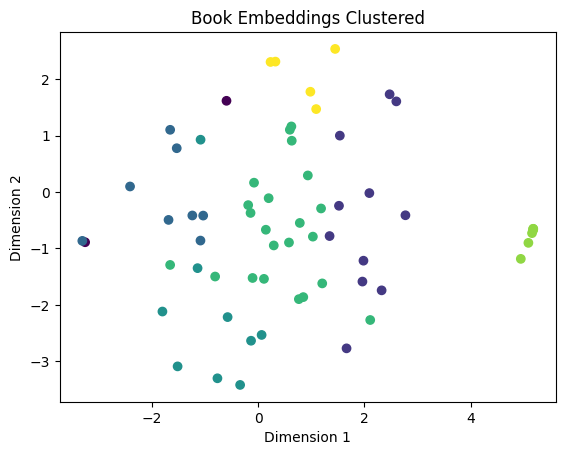

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [28]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [29]:
selected_indices = sorted(closest_indices)
selected_indices

[12, 14, 22, 25, 38, 51, 59]

In [30]:
# Import libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import transformers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
import wandb
run = wandb.init()
artifact = run.use_artifact('olonok69/T5-base-Summarization/T5-base_Summarization_model:v0', type='model')
artifact_dir = artifact.download()
artifact_dir

wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact T5-base_Summarization_model:v0, 472.26MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:5.6


'/content/artifacts/T5-base_Summarization_model:v0'

In [37]:
fine_tune_model=  AutoModelForSeq2SeqLM.from_pretrained(artifact_dir, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [45]:
summarizer = transformers.pipeline("summarization", model=fine_tune_model, tokenizer=tokenizer, device=device)


llm = HuggingFacePipeline(pipeline=summarizer )

# Langchain summarization

https://python.langchain.com/docs/use_cases/summarization

https://blog.langchain.dev/llms-to-improve-documentation/


In [39]:
map_prompt = """
Summarize:
```{text}```
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [40]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [41]:
selected_docs = [docs[doc] for doc in selected_indices]

In [46]:
selected_docs[1].page_content

'“Who doesn’t?” I inquired.\n\n“Gatsby. Somebody told me—”\n\nThe two girls and Jordan leaned together confidentially.\n\n“Somebody told me they thought he killed a man once.”\n\nA thrill passed over all of us. The three Mr. Mumbles bent forward and\nlistened eagerly.\n\n“I don’t think it’s so much that,” argued Lucille sceptically; “It’s\nmore that he was a German spy during the war.”\n\nOne of the men nodded in confirmation.\n\n“I heard that from a man who knew all about him, grew up with him in\nGermany,” he assured us positively.\n\n“Oh, no,” said the first girl, “it couldn’t be that, because he was in\nthe American army during the war.” As our credulity switched back to\nher she leaned forward with enthusiasm. “You look at him sometimes\nwhen he thinks nobody’s looking at him. I’ll bet he killed a man.”\n\nShe narrowed her eyes and shivered. Lucille shivered. We all turned\nand looked around for Gatsby. It was testimony to the romantic\nspeculation he inspired that there were whis

In [47]:
response = summarizer(selected_docs[1].page_content)
response[0]['summary_text']

'– In a book about a German spy who was a spy during World War II, a man who grew up with Gatsby Mumbles was snatched from a library and replaced it with a real one, the New York Times reports. "It\'s a bona-fide piece of printed matter. It fooled me," he cried. "This fella\'s an ordinary Belasco. It\'s the real thing. Pages and—Here! Lemme show you." The book, he said, "foolled me. This fella’s ... a regular Belosco." He cried triumphantly. "What thoroughness! What realism! Knew when to stop, too—didn’t cut the pages. But what do you want? What do you expect?" He returned to the library, where'

In [58]:
import time
t1 = time.perf_counter()
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    #chunk_summary = map_chain.run([doc])
    response = summarizer(doc.page_content)
    chunk_summary = response[0]['summary_text']
    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:500]} \n")

t2 = time.perf_counter()

Summary #0 (chunk #12) - Preview: – The New York Times has a look at the life of a New Yorker who writes a story about a man whose life was ruined when he was a child. Tom Buchanan, who was born in New York and raised in the suburbs of Philadelphia, writes that he grew up in a small town in Pennsylvania, where he lived with his wife, Catherine, and their two daughters. "It was hard for me to get to know them," he tells the Times. "They were a very small town, and they were very different. They were different people, but they had 

Summary #1 (chunk #14) - Preview: – In a book about a German spy who was a spy during World War II, a man who grew up with Gatsby Mumbles was snatched from a library and replaced it with a real one, the New York Times reports. "It's a bona-fide piece of printed matter. It fooled me," he cried. "This fella's an ordinary Belasco. It's the real thing. Pages and—Here! Lemme show you." The book, he said, "foolled me. This fella’s ... a regular Belosco." He cried t

In [60]:
print('time taken to run:',t2-t1)

time taken to run: 34.65239856400012


In [53]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)
text_full = Document(page_content=text)
print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens. Original text has {llm.get_num_tokens(text_full.page_content)}")

Your total summary has 1185 tokens. Original text has 82473


In [50]:
print(summaries.page_content)

– The New York Times has a look at the life of a New Yorker who writes a story about a man whose life was ruined when he was a child. Tom Buchanan, who was born in New York and raised in the suburbs of Philadelphia, writes that he grew up in a small town in Pennsylvania, where he lived with his wife, Catherine, and their two daughters. "It was hard for me to get to know them," he tells the Times. "They were a very small town, and they were very different. They were different people, but they had a lot in common." The Times notes that the story is based on a book by the same name, and it's written by a woman who lived in the town for a long time. The story isn't a new one, but it is a fascinating one, writes
– In a book about a German spy who was a spy during World War II, a man who grew up with Gatsby Mumbles was snatched from a library and replaced it with a real one, the New York Times reports. "It's a bona-fide piece of printed matter. It fooled me," he cried. "This fella's an ordin

In [54]:
len(summaries.page_content), len(text_full.page_content)

(4777, 290101)

In [52]:
text_final = summaries.page_content
docsf = text_splitter.create_documents([text_final])
num_documents = len(docsf)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 1 documents


In [ ]:
# Make an empty list to hold your summaries
summary_final = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(docsf):

    # Go get a summary of the chunk
    #chunk_summary = map_chain.run([doc])
    response = summarizer(doc.page_content)
    chunk_summary = response[0]['summary_text']
    # Append that summary to your list
    summary_final.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:500]} \n")

Summary #0 (chunk #0) - Preview: Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook . 

Summary #1 (chunk #1) - Preview: Tom Gatsby and his wife, Daisy, were married in the middle of June in Louisville, Tennessee . they lived just two doors from the church, and he stayed three weeks until Daddy told him he had to get out. the day after he left Daddy died. “If we were young we’d rise and dance,” said Daisy. “I used to know a Bill Biloxi from Memphis,” she remarked. “He was a friend of his.” “I’d never seen him before.” 



In [ ]:
summary_final = "\n".join(summary_final)

# Convert it back to a document
summaries = Document(page_content=summary_final)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 182 tokens


In [ ]:
print(summaries.page_content)

Project Gutenberg eBook of The Great Gatsby is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever . if you are not located in the US, you will have to check the laws of the country where you are located before using this eBook .
Tom Gatsby and his wife, Daisy, were married in the middle of June in Louisville, Tennessee . they lived just two doors from the church, and he stayed three weeks until Daddy told him he had to get out. the day after he left Daddy died. “If we were young we’d rise and dance,” said Daisy. “I used to know a Bill Biloxi from Memphis,” she remarked. “He was a friend of his.” “I’d never seen him before.”


In [ ]:
len(summaries.page_content)

720